# Multi Layer Perceptron (MLP) 
(c) Deniz Yuret, 2018

* Objectives: See the effect of nonlinearities, learn about regularization and dropout to combat overfitting.
* Prerequisites: Linear models (03.lin.ipynb), AutoGrad, Param, KnetArray, gpu, nll, zeroone
* Knet: xavier, param, param0, relu, dropout (defined and explained)
* Knet: dir, gpu, minibatch, KnetArray (used by mnist.jl)
* Knet: SGD, train!, load, save (used by trainresults)

In [1]:
using Pkg
for p in ("Knet","AutoGrad","Plots")
    haskey(Pkg.installed(),p) || Pkg.add(p)
end

In [2]:
# Load data (see 02.mnist.ipynb)
using Knet: Knet, KnetArray, gpu, minibatch
include(Knet.dir("data","mnist.jl"))  # Load data
dtrn,dtst = mnistdata(xsize=(784,:)); # dtrn and dtst = [ (x1,y1), (x2,y2), ... ] where xi,yi are minibatches of 100

┌ Info: Loading MNIST...
└ @ Main /data/scratch/deniz/.julia/dev/Knet/data/mnist.jl:33


In [3]:
# For running experiments
using Knet: SGD, train!, nll, zeroone
import ProgressMeter
    
function trainresults(file,model; o...)
    if (print("Train from scratch? ");readline()[1]=='y')
        results = Float64[]; updates = 0; prog = ProgressMeter.Progress(60000)
        function callback(J)
            if updates % 600 == 0
                push!(results, nll(model,dtrn), nll(model,dtst), zeroone(model,dtrn), zeroone(model,dtst))
                ProgressMeter.update!(prog, updates)
            end
            return (updates += 1) <= 60000
        end
        train!(model, dtrn; callback=callback, optimizer=SGD(lr=0.1), o...)
        Knet.save(file,"results",reshape(results, (4,:)))
    end
    isfile(file) || download("http://people.csail.mit.edu/deniz/models/tutorial/$file",file)
    results = Knet.load(file,"results")
    println(minimum(results,dims=2))
    return results
end

trainresults (generic function with 1 method)

## Model definition

In [4]:
using AutoGrad: Param

In [5]:
# Redefine Linear model (See 03.lin.ipynb):
struct Linear; w; b; end
(f::Linear)(x) = (f.w * x .+ f.b)

In [6]:
# Linear(inputsize,outputsize) constructs a randomly initalized Linear model:
Linear(inputsize::Int,outputsize::Int) = Linear(param(outputsize,inputsize),param0(outputsize))
param(d...; init=xavier, atype=atype())=Param(atype(init(d...)))
param0(d...; atype=atype())=param(d...; init=zeros, atype=atype)
xavier(o,i) = (s = sqrt(2/(i+o)); 2s .* rand(o,i) .- s)
atype()=(gpu() >= 0 ? KnetArray{Float32} : Array{Float32})

atype (generic function with 1 method)

In [7]:
# MLP is a bunch of linear layers stuck together:
struct MLP; layers; end

In [8]:
# MLP(x,h1,h2,...,hn,y): constructor for a n hidden layer MLP:
MLP(h::Int...)=MLP(Linear.(h[1:end-1], h[2:end]))

MLP

In [9]:
# Here is an example model
model=MLP(784,64,10)
summary.(l.w for l in model.layers)

2-element Array{String,1}:
 "64×784 Param{KnetArray{Float32,2}}"
 "10×64 Param{KnetArray{Float32,2}}" 

## Multiple linear layers do not improve over linear model

In [39]:
using Plots; default(fmt=:png,ls=:auto)
ENV["COLUMNS"]=92

92

In [11]:
# Let us try to just chain multiple linear layers
function (m::MLP)(x)
    for layer in m.layers
        x = layer(x)
    end
    return x
end

In [12]:
# Train a linear model
lin1 = trainresults("lin1.jld2", Linear(784,10)); # 113s [0.241861, 0.266827, 0.0668667, 0.0747]

Train from scratch? stdin> y


Progress: 100%|█████████████████████████████████████████████████████| Time: 0:01:45


[0.241822; 0.266932; 0.0668; 0.0748]


In [13]:
# Train a multi-linear model
mlp1 = trainresults("mlp1.jld2", MLP(784,64,10)); # 110s [0.242123, 0.285064, 0.0697, 0.0799]

Train from scratch? stdin> y


Progress:  99%|████████████████████████████████████████████████████ |  ETA: 0:00:01

[0.242226; 0.286057; 0.0698667; 0.0797]


Progress: 100%|█████████████████████████████████████████████████████| Time: 0:01:55


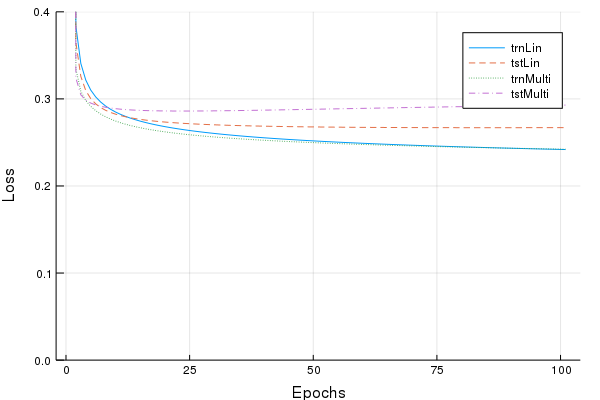

In [40]:
# multilinear converges to a similar solution, not identical because problem is non-convex
plot([lin1[1,:], lin1[2,:], mlp1[1,:], mlp1[2,:]], ylim=(0.0,0.4),
    labels=[:trnLin :tstLin :trnMulti :tstMulti],xlabel="Epochs",ylabel="Loss")  

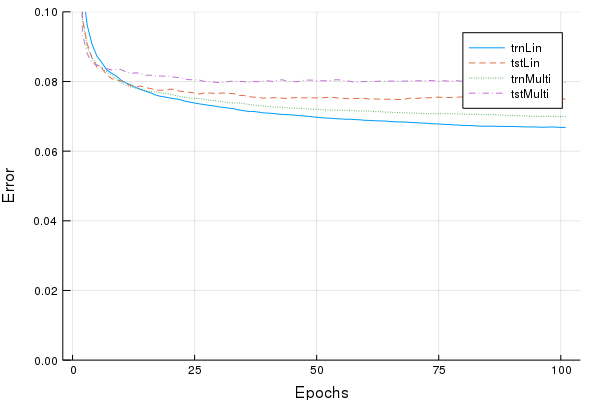

In [41]:
# error results also close to the linear model
plot([lin1[3,:], lin1[4,:], mlp1[3,:], mlp1[4,:]], ylim=(0.0,0.1),
    labels=[:trnLin,:tstLin,:trnMulti,:tstMulti], xlabel="Epochs", ylabel="Error")  

## Multiple linear layers are useless because they are equivalent to a single linear layer
If we write down what is being computed and do some algebra, we can show that what is being computed is still an affine function of the input, i.e. stacking multiple linear layers does not increase the representational capacity of the model:

\begin{align*}
\hat{p} &= \mbox{soft}(W_2 (W_1 x + b_1) + b_2) \\
&= \mbox{soft}((W_2 W_1)\, x + W_2 b_1 + b_2) \\
&= \mbox{soft}(W x + b)
\end{align*}

In [16]:
Knet.gc() # to save gpu memory

## Multi Layer Perceptron (MLP) adds non-linearities between layers

In [17]:
# Using nonlinearities between layers results in a model with higher capacity and helps underfitting
# relu(x)=max(0,x) is a popular function used for this purpose, it replaces all negative values with zeros.
using Knet: relu

In [18]:
function (m::MLP)(x)
    for layer in m.layers
        x = layer(x)
        x = (layer == m.layers[end] ? x : relu.(x))  # <-- This one line makes a big difference
    end
    return x
end

In [19]:
mlp2 = trainresults("mlp2.jld2", MLP(784,64,10));  # 124s [0.00632429, 0.0888991, 0.00055, 0.0259]

Train from scratch? stdin> y


Progress:  99%|████████████████████████████████████████████████████ |  ETA: 0:00:01

[0.00559026; 0.0836753; 0.000416667; 0.0241]


Progress: 100%|█████████████████████████████████████████████████████| Time: 0:02:11


## MLP solves underfitting but still has an overfitting problem

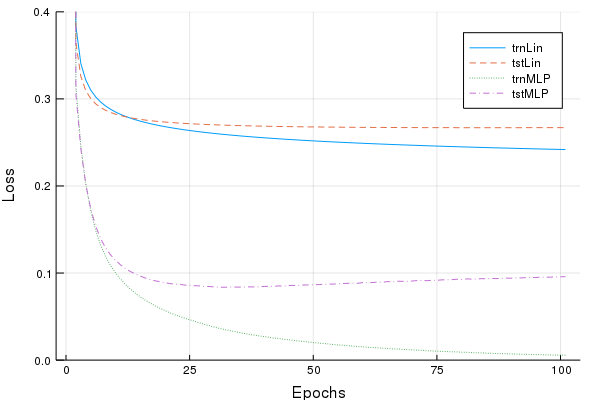

In [42]:
# MLP solves the underfitting problem!  A more serious overfitting problem remains.
plot([lin1[1,:], lin1[2,:], mlp2[1,:], mlp2[2,:]], ylim=(0.0,0.4),
     labels=[:trnLin :tstLin :trnMLP :tstMLP],xlabel="Epochs",ylabel="Loss")

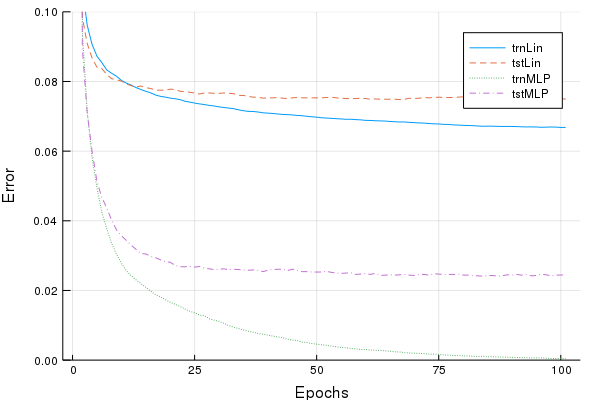

In [43]:
# Test error improves from 7.5% to 2.3%!
plot([lin1[3,:], lin1[4,:], mlp2[3,:], mlp2[4,:]], ylim=(0.0,0.1),
    labels=[:trnLin,:tstLin,:trnMLP,:tstMLP], xlabel="Epochs", ylabel="Error")  

In [22]:
Knet.gc() # to save gpu memory

## MLP with L1 regularization

In [23]:
# Define new loss functions for L1 and L2 regularization
using Knet: nll
nll1(m::MLP,x,y; λ=0, o...) = nll(m,x,y; o...) + λ * sum(sum(abs, l.w) for l in m.layers)
nll2(m::MLP,x,y; λ=0, o...) = nll(m,x,y; o...) + λ * sum(sum(abs2,l.w) for l in m.layers)

nll2 (generic function with 1 method)

In [24]:
mlp3 = trainresults("mlp3.jld2", MLP(784,64,10); loss=nll1, λ=4f-5); # 133s [0.0262292, 0.0792939, 0.0066, 0.0237]

Train from scratch? stdin> y


Progress:  99%|████████████████████████████████████████████████████ |  ETA: 0:00:01

[0.0268914; 0.0828166; 0.00666667; 0.0246]


Progress: 100%|█████████████████████████████████████████████████████| Time: 0:02:29


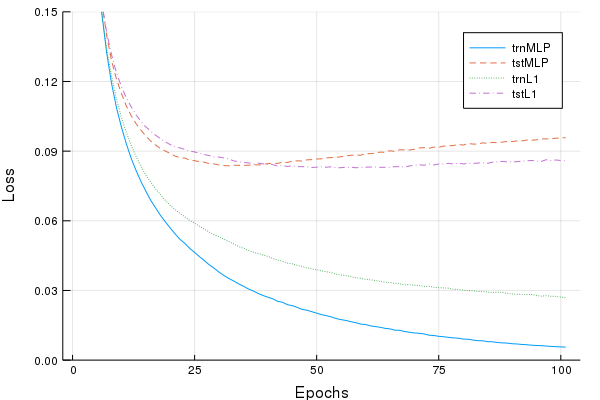

In [44]:
# overfitting less, test loss improves from 0.0808 to 0.0759
plot([mlp2[1,:], mlp2[2,:], mlp3[1,:], mlp3[2,:]], ylim=(0.0,0.15),
     labels=[:trnMLP :tstMLP :trnL1 :tstL1],xlabel="Epochs",ylabel="Loss")

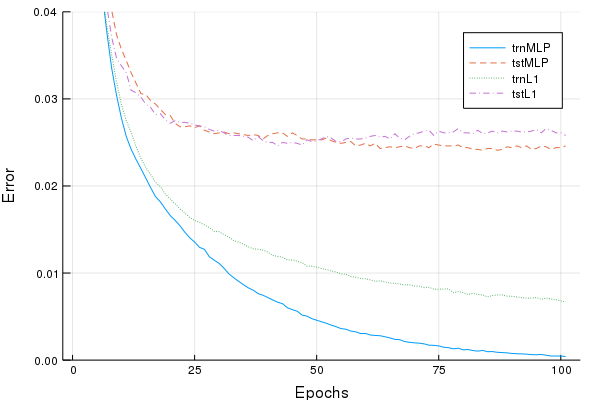

In [45]:
# however test error does not change significantly: 0.0235 -> 0.0220
plot([mlp2[3,:], mlp2[4,:], mlp3[3,:], mlp3[4,:]], ylim=(0.0,0.04),
     labels=[:trnMLP :tstMLP :trnL1 :tstL1],xlabel="Epochs",ylabel="Error")

In [27]:
Knet.gc() # to save gpu memory

## MLP with dropout

In [28]:
using Knet: dropout
@doc dropout

```
dropout(x, p)
```

Given an array `x` and probability `0<=p<=1`, just return `x` if `p==0`, or return an array `y` in which each element is 0 with probability `p` or `x[i]/(1-p)` with probability `1-p`.  Use `seed::Number` to set the random number seed for reproducible results. See [(Srivastava et al. 2014)](http://www.jmlr.org/papers/v15/srivastava14a.html) for a reference.


In [29]:
# Dropout is another way to address overfitting
function (m::MLP)(x; pdrop=0)
    for (i,layer) in enumerate(m.layers)
        p = (i <= length(pdrop) ? pdrop[i] : pdrop[end])
        x = dropout(x, p)     # <-- This one line helps generalization
        x = layer(x)
        x = (layer == m.layers[end] ? x : relu.(x))
    end
    return x
end

In [30]:
mlp4 = trainresults("mlp4.jld2", MLP(784,64,10); pdrop=(0.2,0.0));  # 119s [0.0126026, 0.0648639, 0.0033, 0.0189]

Train from scratch? stdin> y


Progress:  99%|████████████████████████████████████████████████████ |  ETA: 0:00:01

[0.0125352; 0.0625746; 0.00311667; 0.0185]


Progress: 100%|█████████████████████████████████████████████████████| Time: 0:02:15


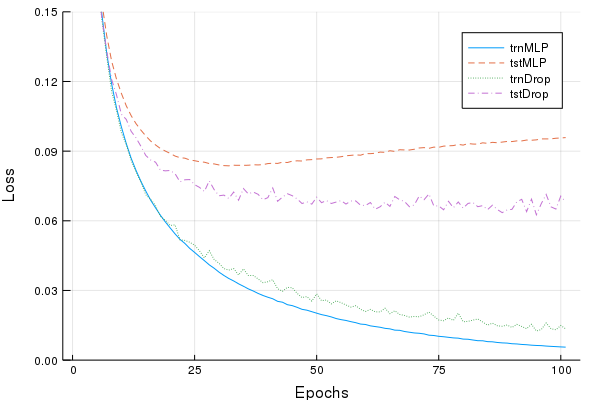

In [46]:
# overfitting less, loss results improve 0.0808 -> 0.0639
plot([mlp2[1,:], mlp2[2,:], mlp4[1,:], mlp4[2,:]], ylim=(0.0,0.15),
     labels=[:trnMLP :tstMLP :trnDrop :tstDrop],xlabel="Epochs",ylabel="Loss")

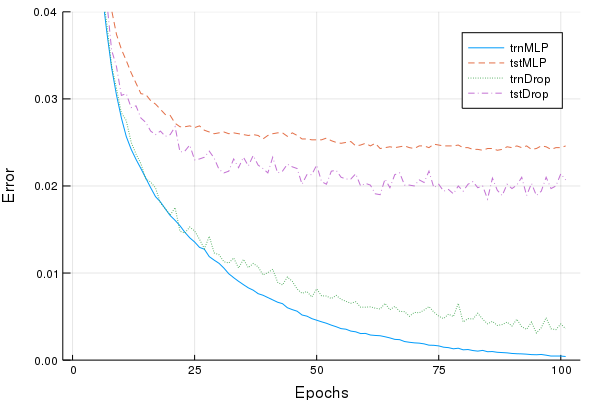

In [47]:
# this time error also improves 0.0235 -> 0.0188
plot([mlp2[3,:], mlp2[4,:], mlp4[3,:], mlp4[4,:]], ylim=(0.0,0.04),
     labels=[:trnMLP :tstMLP :trnDrop :tstDrop],xlabel="Epochs",ylabel="Error")

In [33]:
println([:mlperr,minimum(mlp2[4,:]),:L1err,minimum(mlp3[4,:]),:dropouterr,minimum(mlp4[4,:])])

Any[:mlperr, 0.0241, :L1err, 0.0246, :dropouterr, 0.0185]


In [34]:
println([:mlploss,minimum(mlp2[2,:]),:L1loss,minimum(mlp3[2,:]),:dropoutloss,minimum(mlp4[2,:])])

Any[:mlploss, 0.0836753, :L1loss, 0.0828166, :dropoutloss, 0.0625746]


In [35]:
Knet.gc() # to save gpu memory

## MLP with larger hidden layer and dropout

In [36]:
# The current trend is to use models with higher capacity tempered with dropout
mlp = trainresults("mlp.jld2", MLP(784,256,10); pdrop=(0.2,0.0));  # 123s [0.00365709, 0.0473298, 0.000283333, 0.0141]

Train from scratch? stdin> y


Progress:  99%|████████████████████████████████████████████████████ |  ETA: 0:00:01

[0.00378384; 0.0492734; 0.000316667; 0.0149]


Progress: 100%|█████████████████████████████████████████████████████| Time: 0:02:17


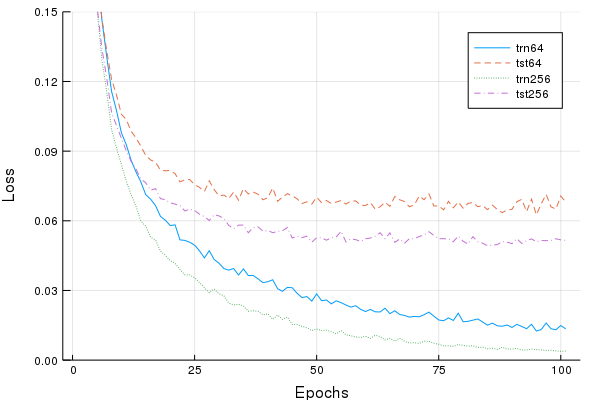

In [48]:
plot([mlp4[1,:], mlp4[2,:], mlp[1,:], mlp[2,:]],ylim=(0,0.15),
    labels=[:trn64 :tst64 :trn256 :tst256],xlabel="Epochs",ylabel="Loss")

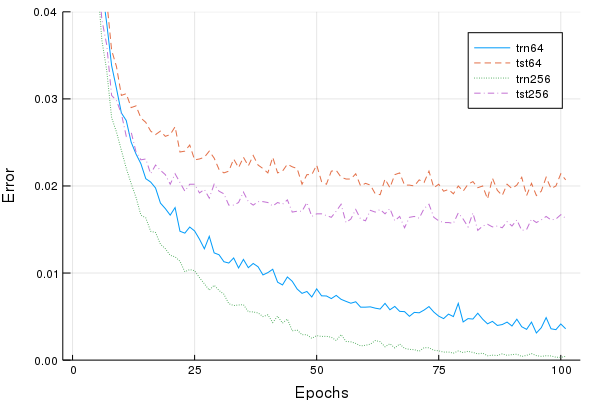

In [49]:
# We are down to 0.015 error.
plot([mlp4[3,:], mlp4[4,:], mlp[3,:], mlp[4,:]],ylim=(0,0.04),
    labels=[:trn64 :tst64 :trn256 :tst256],xlabel="Epochs",ylabel="Error")